# Введение

Реализация алгоритма K-Means

In [170]:
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import time
import seaborn as sns
from copy import copy, deepcopy
%matplotlib inline

Я реализовал алгоритм KMeans как класс с возможностью выбора параметров:

*   число центров
*   максимальное число шагов
*   необходимая точность
*   алгоритм инициализации
*   размерность
*   число повторений для выбора лучшего результата

При реализации я старался как можно больше действий реализовывать при помощи работы с numpy, чтобы получить высокую скорость работы.

# Реализация DBSCAN

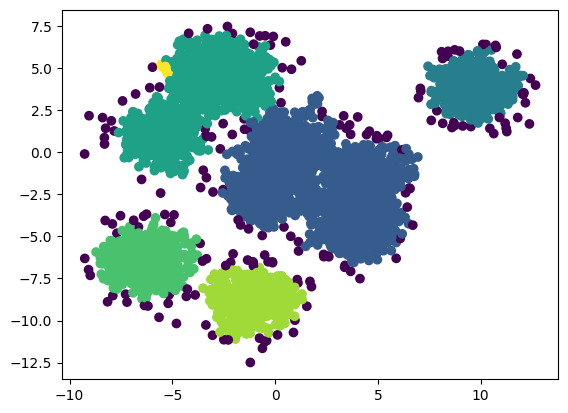

In [197]:
class DBscan():
    def __init__(self, eps=0.5, samples_min=5):
        self.eps = eps
        self.samples_min = samples_min
        self.clusters_cnt = 0
        self.labels = np.zeros(X.shape[0])


    def fit(self, X):
        near = NearestNeighbors(radius=self.eps)
        near.fit(X)
        
        for p in range(0, X.shape[0]):
            if self.labels[p] != 0:
                continue
            neighbors = near.radius_neighbors([X[p]], radius=self.eps, return_distance=False)
            if neighbors[0].shape[0] < self.samples_min:
                self.labels[p] = -1
                continue
            self.clusters_cnt += 1
            self.labels[p] = self.clusters_cnt
            
            points = []
            points.extend(neighbors[0])
            q_index = 0
            set_points = set(neighbors[0])
            while q_index < len(points):
                q = points[q_index]
                q_index += 1
                if self.labels[q] == -1:
                    self.labels[q] = self.clusters_cnt
                if self.labels[q] != 0:
                    continue
                self.labels[q] = self.clusters_cnt
                neighbors = near.radius_neighbors([X[q]], radius=self.eps, return_distance=False)
                if neighbors[0].shape[0] >= self.samples_min:
                    for h in neighbors[0]:
                        if h not in set_points:
                            points.append(h)
                            set_points.add(h)


    def fit_predict(self, X):
        self.fit(X)
        return self.labels


X, y = datasets.make_blobs(n_samples = 5000, n_features = 2, centers = 10, random_state = 123)
model = DBscan(eps=0.4, samples_min=5)
colors = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = colors)
plt.show()

# Реализация KMeans, KMeans++

In [198]:
class KMeans_my():
    def __init__(self, centroids_cnt = 2, max_iter = 300, eps = 1e-4, algo = 'plusplus', dim = 2, n_init = 5):
        self.centroids_cnt = centroids_cnt
        self.max_iter = max_iter
        self.centroids = np.empty(shape=(centroids_cnt, dim))
        self.eps = eps
        self.algo = algo
        self.algos = {'standart' : KMeans_my.generate_centroids_standart,
                      'plusplus' : KMeans_my.generate_centroids_plusplus,
                      'bymass' : KMeans_my.generate_centroids_bymass}
        self.n_init = n_init
    

    def generate_centroids_standart(X, centroids_cnt):
        return X[np.random.choice(X.shape[0], centroids_cnt, replace = 0)].copy()


    def generate_centroids_plusplus(X, centroids_cnt):
        ans = np.full((centroids_cnt, X[0].shape[0]), X[np.random.choice(X.shape[0], 1)].copy())
        a = norm(X - ans[0], axis = 1) ** 2
        for i in range(1, centroids_cnt):
            b = norm(X - ans[i - 1], axis = 1) ** 2
            to_update = a > b
            a[to_update] = b[to_update]
            cumsum = np.cumsum(a)
            chosen = np.random.random() * cumsum[-1]
            ans[i] = X[np.where(cumsum >= chosen)[0][0]].copy()
        return ans


    def generate_centroids_bymass(X, centroids_cnt):
        ans = np.full((centroids_cnt, X[0].shape[0]), X[np.random.choice(X.shape[0], 1)].copy())
        for i in range(1, centroids_cnt):
            center = np.mean(ans[:i], axis = 0)
            a = norm(X - center, axis=1)
            cumsum = np.cumsum(a)
            chosen = np.random.random() * cumsum[-1]
            ans[i] = X[np.where(cumsum >= chosen)[0][0]].copy()
        return ans
    

    def find_clusters(X, centroids):
        return np.argmin(euclidean_distances(centroids, X), axis = 0)


    def find_centroids(X, colors, centroids):
        centroids_new = np.array([np.mean(X[colors == i], axis=0) for i in range(0, centroids.shape[0])])
        return centroids_new


    def check_accuracy(centers, centers_old, eps):
        center_shift_tot = ((centers - centers_old) ** 2).sum()
        return center_shift_tot <= eps


    def choose_algo(algo, algos):
        try:
            return algos[algo]
        except KeyError:
            print('Such algorithm does not exist, so applying standart one. Existing ones:',
                  *(algos.keys()), sep='\n', end='\n\n\n')
            return algos['standart']


    def loss(X, colors, centroids):
        ans = 0
        for i in range(0, centroids.shape[0]):
            ans += np.sum(norm(X[np.where(colors == i)] - centroids[i]))
        return ans


    def fit(self, X):
        self.eps *= np.mean(np.var(X, axis=0))
        best = np.empty(self.centroids_cnt)
        loss_best = -1

        for i in range(self.n_init):
            generator = KMeans_my.choose_algo(self.algo, self.algos)
            self.centroids = generator(X, self.centroids_cnt)
            a = KMeans_my.find_clusters(X, self.centroids)
            for j in range(0, self.max_iter):
                new_centroids = KMeans_my.find_centroids(X, a, self.centroids)
                if KMeans_my.check_accuracy(new_centroids, self.centroids, self.eps): break
                self.centroids = new_centroids
                a = KMeans_my.find_clusters(X, self.centroids)
            loss_cur = KMeans_my.loss(X, a, self.centroids)
            if loss_best == -1 or loss_cur < loss_best:
                best = deepcopy(self.centroids)
                loss_best = loss_cur
        
        self.centroids = deepcopy(best)
    
    
    def predict(self, X):
        colors = KMeans_my.find_clusters(X, self.centroids)
        return colors

    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

# Приложение для 3-мерного случая

Алгоритм KMeans использует универсальную метрику, поэтому способен работать не только в 2 измерениях. Кластеризация точек в измерениях большей размерности происходит аналогично.

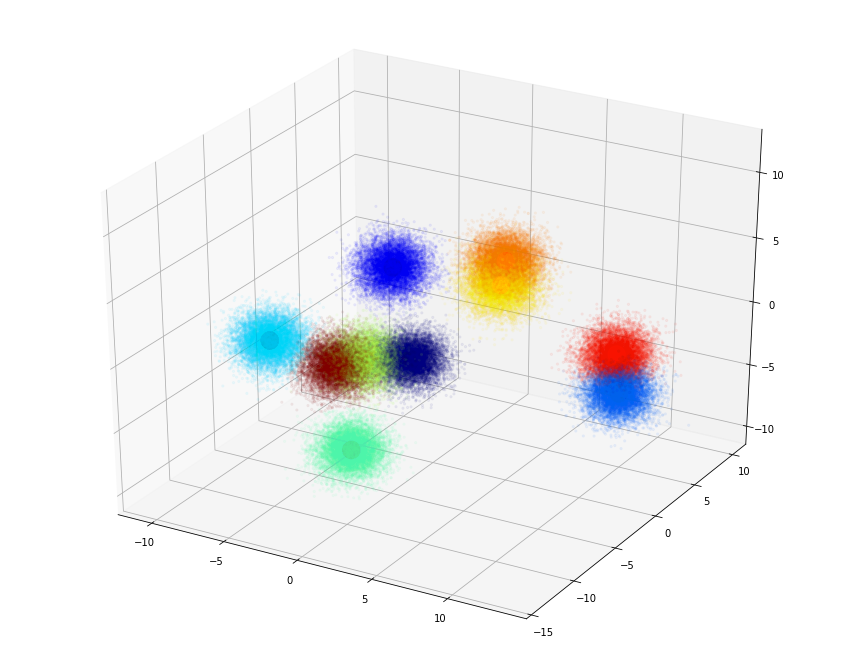

In [ ]:
X, y = datasets.make_blobs(n_samples = 100000, n_features = 3, centers = 10)
model = KMeans_my(centroids_cnt = 10, dim = 3)
colors = model.fit_predict(X)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = colors, cmap = 'jet', s = 5, alpha = 0.05)
ax.scatter(model.centroids[:, 0], model.centroids[:, 1], model.centroids[:, 2], c = 'Red', s = 300)
plt.show()

# Пункт 1. Стратегии начальной инициализации

Для начальной инициализации рассмотрим 3 разных метода.

1) Случайные точки - случайным образом выберем нужное число точек из имеющихся, приняв их за начальные центроиды.


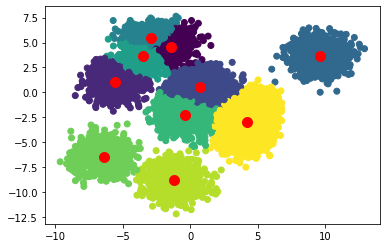

In [ ]:
X, y = datasets.make_blobs(n_samples = 10000, n_features = 2, centers = 10, random_state = 123)
model = KMeans_my(centroids_cnt = 10, eps = 1e-4, algo = 'standart')
colors = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = colors)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c = 'Red', s = 100)
plt.show()

2) Kmeans++ - первая точка берется случайно, а остальные - случайно, с вероятностью выбора пропорциональной квадрату расстояния до уже взятого ближайшего центроида.

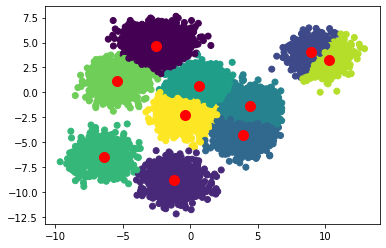

In [ ]:
X, y = datasets.make_blobs(n_samples = 10000, n_features = 2, centers = 10, random_state = 123)
model = KMeans_my(centroids_cnt = 10, eps = 1e-4, algo = 'plusplus')
colors = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = colors)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c = 'Red', s = 100)
plt.show()

3) От центра масс - модифицируем kmeans++, беря новые точки пропорционально не квадрату расстояния о ближайшего центроида, а расстоянию до центра масс уже взятых центроидов.

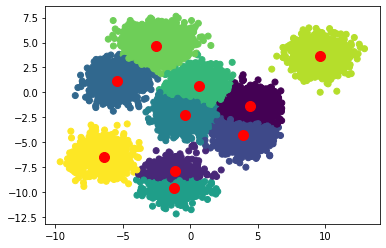

In [ ]:
X, y = datasets.make_blobs(n_samples = 10000, n_features = 2, centers = 10, random_state = 123)
model = KMeans_my(centroids_cnt = 10, eps = 1e-4, algo = 'bymass')
colors = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = colors)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c = 'Red', s = 100)
plt.show()

# Пункт 2. Для каких задач подходит



KMeans будет хорошо работать на датасетах с примерно шарообразными и равномощными кластерами:

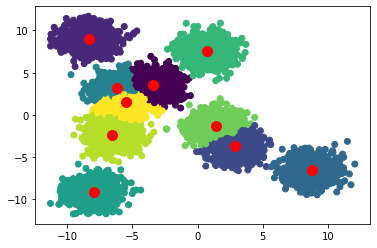

In [ ]:
X, y = datasets.make_blobs(n_samples = 10000, n_features = 2, centers = 10)
model = KMeans_my(centroids_cnt = 10, eps = 1e-4, algo = 'plusplus')
colors = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = colors)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c = 'Red', s = 100)
plt.show()

Однако если границы кластеров размыты, алгоритм будет справляться хуже:

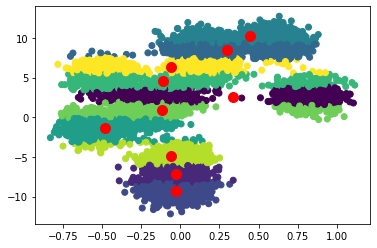

In [ ]:
X, y = datasets.make_blobs(n_samples = 10000, n_features = 2, centers = 10)
X[:, 0] /= 10
model = KMeans_my(centroids_cnt = 10, eps = 1e-4, algo = 'plusplus')
colors = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = colors)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c = 'Red', s = 100)
plt.show()

Также он будет выполняться хуже, если кластеры трудно выделить в шарообразной форме:

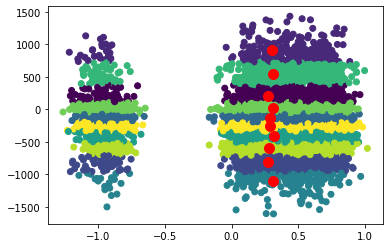

In [ ]:
X, y = datasets.make_blobs(n_samples = 10000, n_features = 2, centers = 10)
X[:, 0] /= 10
X[:, 1] **= 3
np.random.shuffle(X[:, 0])
X[:, :] = X[np.random.shuffle(X[:, 0]), :]
model = KMeans_my(centroids_cnt = 10, eps = 1e-4, algo = 'plusplus')
colors = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = colors)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c = 'Red', s = 100)
plt.show()

# Пункт 3. Стратегия выбора числа кластеров

Выбор оптимального числа кластеров будем осуществлять "методом локтя". В качестве метрики возьмем сумму квадратов расстояний от каждой точки до ее центра. По каждому числу кластеров нанесем соответствующую точку на график, а затем найдем ту точку, в которой метрика начинает уменьшаться линейно и примем ее за подходящее число кластеров.

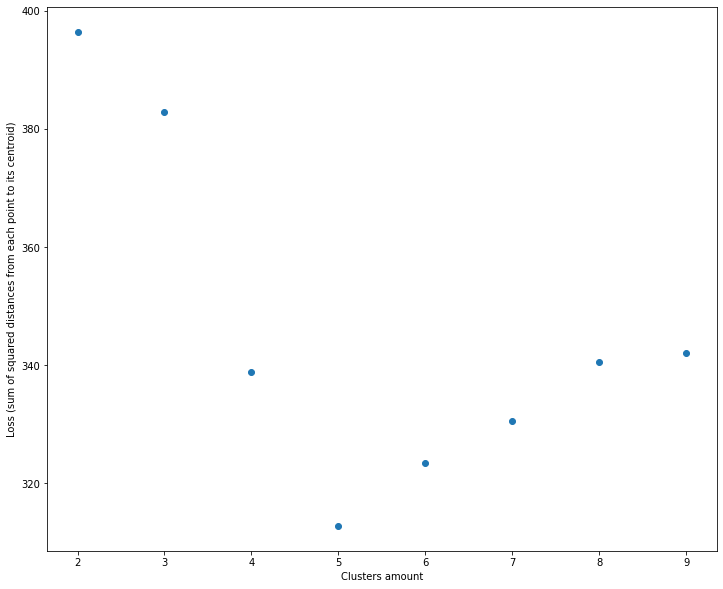

In [ ]:
X, y = datasets.make_blobs(n_samples = 10000, n_features = 2, centers = 5)
loss = np.empty((2, 8))
for i in range(2, 10):
    model = KMeans_my(centroids_cnt=i)
    model.fit(X)
    colors = model.predict(X)
    loss[0][i-2] = i
    loss[1][i-2] = KMeans_my.loss(X, colors, model.centroids)

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(loss[0], loss[1])
ax.set_xlabel('Clusters amount')
ax.set_ylabel('Loss (sum of squared distances from each point to its centroid)')
plt.show()

# Пункт 4. Исследование зависимости скорости настройки от сложности задачи

Построим графики зависимости времени настройки от числа точек, беря разное число кластеров.

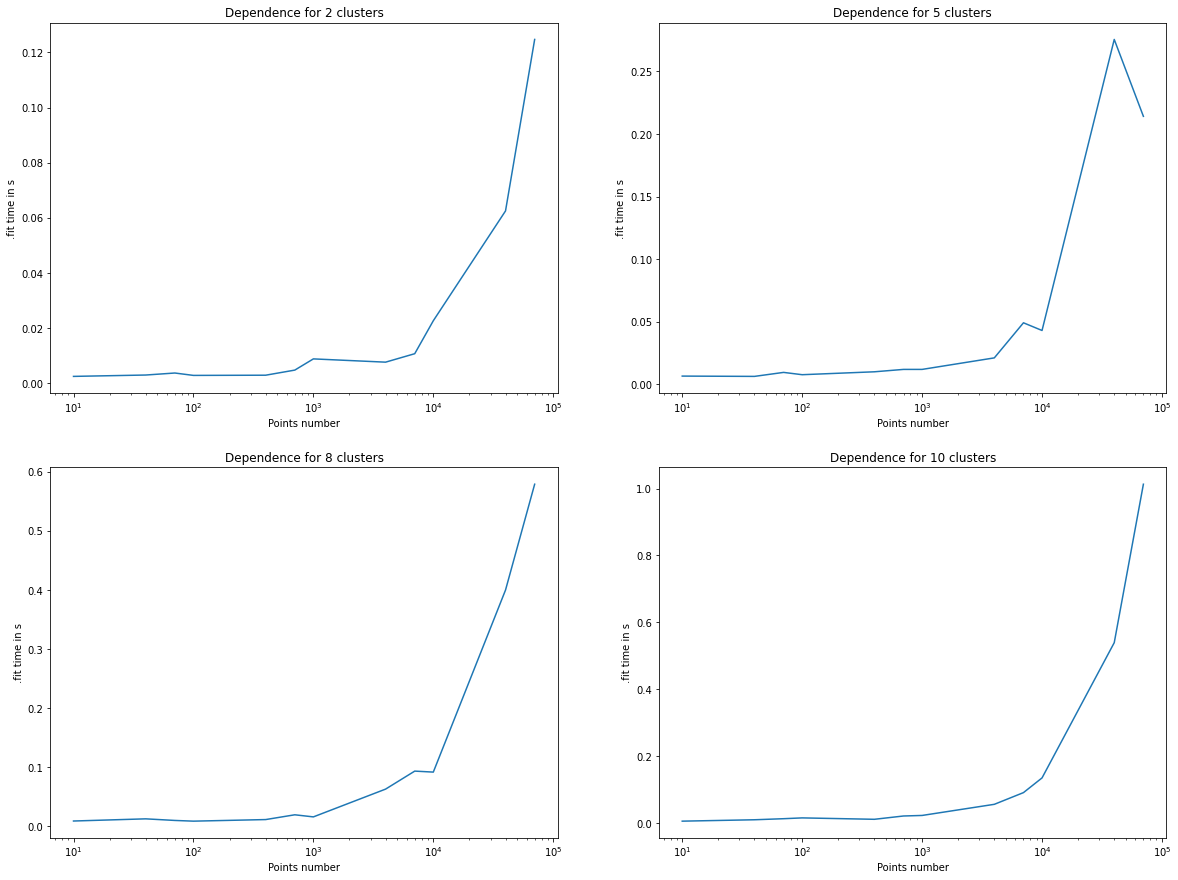

In [ ]:
test_blobs = [i * j for i in [10, 100, 1000, 10000] for j in range(1, 10, 3)]
clusters = [2, 5, 8, 10]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

for c in range(len(clusters)):
    draw = np.empty((2, len(test_blobs)))
    for i in range(len(test_blobs)):
        timer = 0
        for j in range(3):
            dataset, y = datasets.make_blobs(n_samples = test_blobs[i], n_features = 2, centers = clusters[c])
            model = KMeans_my(centroids_cnt = clusters[c], n_init = 3)
            time_start = time.perf_counter()
            model.fit(dataset)
            timer += time.perf_counter() - time_start
        timer /= 3
        draw[0, i] = test_blobs[i]
        draw[1, i] = timer
    
    ax = axs[(c // axs.shape[0], c % axs.shape[1])]
    ax.plot(draw[0], draw[1])
    ax.set_title(f'Dependence for {clusters[c]} clusters')
    ax.set_xlabel('Points number')
    ax.set_ylabel('.fit time in s')
    ax.set_xscale('log')

plt.show()

# Пункт 5. Визуализация матрицы попарных расстояний
Чтобы распознать кластеры на графике, необходимо поставить точки из одного кластера друг с другом. Для этого последовательно склеим выбранные по каждому кластеру точки, получив новый массив. Теперь, визуализировав полученную матрицу попарных расстояний при помощи heatmap из seaborn, можно распознать на графике точки из одного кластера.

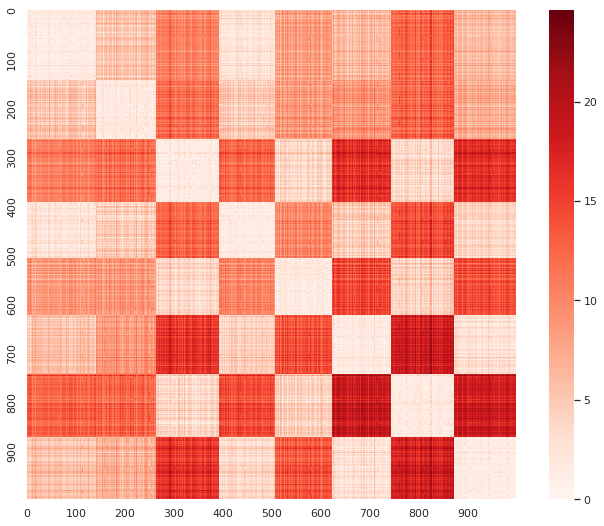

In [ ]:
def get_pair_destances_matrix(X, colors):
    Y = X[np.where(colors == 0)]
    for i in range(1, model.centroids_cnt):
        Y = np.concatenate((Y, X[np.where(colors == i)]))
    return euclidean_distances(Y)


X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=8)
model = KMeans_my(centroids_cnt=8, eps=1e-4, algo='plusplus')
colors = model.fit_predict(X)

g = get_pair_destances_matrix(X, colors)

sns.set(rc={'figure.figsize' : (12,9)})
sns.heatmap(g, xticklabels=g.shape[0] // 10, yticklabels=g.shape[0] // 10, square=1, cmap='Reds')
plt.show()

# Заключение

***Использованные материалы***

https://github.com/Dyakonov/IML/blob/master/2020/IML2020_04cluster_01.pdf - постановка задачи

https://en.wikipedia.org/wiki/K-means%2B%2B - идея для KMeans++

https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/cluster/_kmeans.py - идея для проверки точности и некоторые мелкие заимствования

https://scikit-learn.org/stable/ - документация по sklearn

https://seaborn.pydata.org/ - документация по seaborn

https://numpy.org/doc/stable/ - документация по numpy

https://matplotlib.org/ - документация по matplotlib

